# Setup

In [1]:
DATA_VERSION = "2025-07-14"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    # "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40
IGNORE_TOPICS = {
    # "administration",
    # "communications",
}

DOC_TYPES = {
    "DRAFT",
    # None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    # "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271

In [2]:
%load_ext autoreload
%autoreload 2

import pathlib
import sys

import dotenv
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
# nltk.download("stopwords")

In [4]:
import demokratis_ml.models.consultation_topics.preprocessing
from research.lib import data_access, plotting, stratified_group_split, utils

In [5]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_classical_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = classy-grub-138


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/15 10:08:16 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-14.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
21,1CAJoURregQSBjKq3Pp2mL,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,Bundesamt für Kommunikation,ch,1CM3wg6vz2uQ3oZqEQcf7s,fedlex,manual,fedlex,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...,2024/2/22/1CM3wg6vjrx6u67JD8PayD.pdf,application/pdf,8fb68017e53055498c277ed8afe60d56ee2935aa
42,1CAJoUSHBj4qdYJPe3PFcd,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgUgRrjEFontegfgyd,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/43/1CM3wgUcDxsq2yKqdZsaGe.pdf,application/pdf,98a60f2d0b0b0ce18b5ce82a1e9df248c3629bb9
51,1CAJoUSHBj4qdYJPedbRja,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgwv3CkfxghjShq2NP,fedlex,manual,fedlex,1 \nRaumplanungsverordnung \n \nVernehmlassung...,2024/3/52/1CM3wgwuYYGtzYePP6ETCu.pdf,application/pdf,0ec7371d74bfec45d6b022706fe669bee7005ded
54,1CAJoUSHBj4qdYJPepDs22,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgyzoKLLbozGmFEg75,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/55/1CM3wgyzJL2fSpmyQyW3Uj.pdf,application/pdf,fc01f855d3a18f17ee7b3b9add690ded4d9d2764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53959,1CQXzKRuXrxxk6ymwxFVdW,end6g7hp,2025-06-25,2025-10-15,Änderung des Wasserrechtsgesetzes (Umsetzung M...,Gegenstand der vorliegenden Vernehmlassungsvor...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/end6g7hp,"[energy, environment]","[{'created_at': 2025-05-07 14:07:37, 'name': '...",...,Bundesamt für Energie,ch,1CQdqZXWjjq9rvKbTVwpfU,fedlex,manual,fedlex,«$$e-seal»\n«$$QrCode»\n2024-...\n«%ASFF_YYYY_...,2025/5113/55961/1CQdqZXWVqhRV7H1wXgf1V.pdf,application/pdf,0df91a8ba027b8a2a481771fd88328e066dcf57a
53974,1CQXzKTmtroZUKrXVYMHQq,jh9ctnan,2025-06-25,2025-10-16,Verordnungspaket Umwelt Frühling 2026,"Anpassu

## Create the input dataframe

In [9]:
def documents_to_consultation(x: pd.DataFrame) -> pd.Series:
    def get(key: str) -> str:
        return x[key].iloc[0]

    return pd.Series(
        {
            "text": "\n\n".join(
                [
                    get("consultation_title"),
                    get("consultation_description"),
                    get("organisation_name"),
                    *x["document_content_plain"].tolist(),
                ]
            ),
            "consultation_topics": get("consultation_topics"),
            "consultation_topics_label_source": get("consultation_topics_label_source"),
        }
    )


df_input = (
    df_docs[df_docs["document_content_plain"].str.strip() != ""]
    .groupby("consultation_identifier")
    .apply(documents_to_consultation)
    .reset_index()
)
df_input

/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_88518/1003818624.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(documents_to_consultation)


,consultation_identifier,text,consultation_topics,consultation_topics_label_source
0,2259wqvq,Revision der Asylverordnung 2 über Finanzierun...,"[migration, public_finance]",manual
1,22mkgk7j,Änderung der Verordnung über die CO2-Abgabe (C...,"[energy, environment, housing, public_finance]",manual
2,22rhfj95,Änderung der Verordnung über die Bekämpfung de...,"[finance, foreign_policy, security]",manual
3,254aynz4,Änderung des Elektrizitätsgesetzes (Beschleuni...,[energy],manual
4,26j4aved,Anhörung zur Änderung der Energieverordnung (E...,"[energy, environment, public_finance]",manual
...,...,...,...,...
1044,zygt9epc,Teilrevision des Strahlenschutzgesetzes (StSG)...,"[energy, health, security]",manual
1045,zyuux9us,Fischereigesetz\n\nDer Regierungsrat des Kanto...,"[agriculture, environment, social]",manual
1046,zzby35xf,08.520 Parlamentarische Initiative. Abschaffun...,"[insurance, sports, transportation]",manual
1047,zzvn2q9r,Bundesgesetz über die Besteuerung des mobilen ...,"[economics, foreign_policy, public_finance]",manual


In [10]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.encode_topics(df_input)
df_input

,consultation_identifier,text,consultation_topics,consultation_topics_label_source,topic_administration,topic_agriculture,topic_communications,topic_culture,topic_defense,topic_economics,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
0,2259wqvq,Revision der Asylverordnung 2 über Finanzierun...,"[migration, public_finance]",manual,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,22mkgk7j,Änderung der Verordnung über die CO2-Abgabe (C...,"[energy, environment, housing, public_finance]",manual,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,22rhfj95,Änderung der Verordnung über die Bekämpfung de...,"[finance, foreign_policy, security]",manual,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,254aynz4,Änderung des Elektrizitätsgesetzes (Beschleuni...,[energy],manual,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26j4aved,Anhörung zur Änderung der Energieverordnung (E...,"[energy, environment, public_finance]",manual,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,zygt9epc,Teilrevision des Strahlenschutzgesetzes (StSG)...,"[energy, health, security]",manual,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1045,zyuux9us,Fischereigesetz\n\nDer Regierungsrat des Kanto...,"[agriculture, environment, social]",manual,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1046,zzby35xf,08.520 Parlamentarische Initiative. Abschaffun...,"[insurance, sports, transportation]",manual,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1047,zzvn2q9r,Bundesgesetz über die Besteuerung des mobilen ...,"[economics, foreign_policy, public_finance]",manual,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## Drop underrepresented topics

In [11]:
df_input, topic_columns = demokratis_ml.models.consultation_topics.preprocessing.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
 topic_culture             38
topic_media               11
topic_political_system    37
topic_sports              28
dtype: int64
Dropping these documents without any label: 2


In [12]:
print("Original number of documents:", df_docs.shape[0])
print("df_input size (consultations):", df_input.shape[0])

Original number of documents: 1615
df_input size (consultations): 1047


## Split

In [13]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(
    splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_identifier"])
)

In [14]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

assert not set(df_input_train["consultation_identifier"]) & set(
    df_input_test["consultation_identifier"]
), "No leakage between train and test sets"

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (940, 26)
Test: (107, 26)


# Data exploration

In [15]:
df_input_train.groupby("consultation_identifier").agg({"consultation_topics": "first"}).explode(
    "consultation_topics"
).value_counts()

consultation_topics
economics              221
public_finance         205
security               180
health                 155
administration         149
foreign_policy         130
it                     124
social                 110
environment            108
finance                103
transportation          95
insurance               94
energy                  88
agriculture             86
migration               79
education               71
law                     71
spatial_planning        67
housing                 52
communications          49
defense                 40
science                 40
political_system        34
culture                 31
sports                  20
media                    8
Name: count, dtype: int64

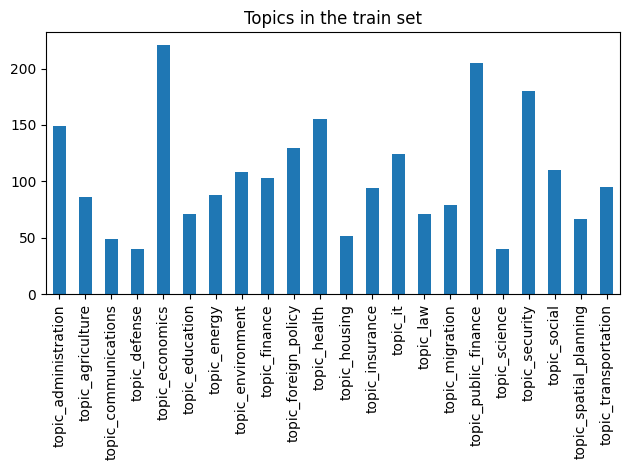

In [16]:
plotting.plot_and_log(
    df_input_train[topic_columns].sum().plot.bar,
    "figures/topics-counts-train.png",
    title="Topics in the train set",
)

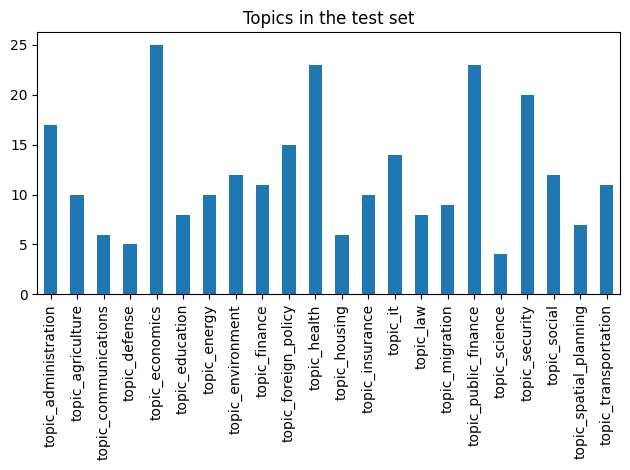

In [17]:
plotting.plot_and_log(
    df_input_test[topic_columns].sum().plot.bar,
    "figures/topics-counts-test.png",
    title="Topics in the test set",
)

# Classification

In [18]:
def create_matrices(df: pd.DataFrame) -> tuple[pd.Series, pd.DataFrame]:
    x = df["text"]
    y = df[topic_columns]
    return x, y


def create_classifier(random_state: int) -> Pipeline:
    stop_words = [
        *nltk.corpus.stopwords.words("german"),
        # TODO: there's more noise that could be added here
        # e.g. "sr \d{3}"
        "asff_yyyy_id",
        "vernehmlassung",
    ]
    return make_pipeline(
        TfidfVectorizer(
            max_features=50_000,
            ngram_range=(1, 2),
            stop_words=stop_words,
        ),
        OneVsRestClassifier(
            LogisticRegression(solver="liblinear", class_weight="balanced"),
            n_jobs=-1,
        ),
    )


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)

groups_train = df_input_train["consultation_identifier"]
groups_test = df_input_test["consultation_identifier"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (940,) (940, 22)
Test (107,) (107, 22)


## CV

In [19]:
classifier_cv = create_classifier(RANDOM_STATE)
classifier_cv

,steps,"[('tfidfvectorizer', ...), ('onevsrestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [20]:
cv = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


# def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
#     """If PCA is used in the pipeline, include its explained variance in scores."""
#     try:
#         pca = pipeline.named_steps["pca"]
#     except KeyError:
#         return np.nan
#     explained_variance = np.sum(pca.explained_variance_ratio_)
#     return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "groups": groups_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores_docs = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        # "pca_explained_variance": explained_variance_scorer,
    },
)
display(cv_scores_docs)

print("\ncross_val_predict...")
y_cv_predicted_docs = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type =

[CV] END .................................................... total time=   6.0s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv

[CV] END .................................................... total time=   6.4s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.8s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished


{'fit_time': array([5.03613782, 6.42682195, 5.75201321, 5.59147692, 5.97222686]),
 'score_time': array([0.96712303, 0.39392996, 0.7445209 , 0.83513403, 0.57693624]),
 'test_precision': array([0.67054054, 0.66225225, 0.68192982, 0.67815199, 0.64777184]),
 'test_recall': array([0.56801802, 0.55720721, 0.57105263, 0.59412781, 0.5815508 ]),
 'test_f1': array([0.57491634, 0.57567568, 0.58481203, 0.59467061, 0.58113063])}


cross_val_predict...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


In [21]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores_docs.items() if k.startswith("test_")})

{'cv_f1': 0.5822, 'cv_precision': 0.6681, 'cv_recall': 0.5744}


In [22]:
report = sklearn.metrics.classification_report(
    y_train, y_cv_predicted_docs, zero_division=np.nan, target_names=topic_columns
)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)

                        precision    recall  f1-score   support

  topic_administration       0.48      0.46      0.47       149
     topic_agriculture       0.85      0.70      0.76        86
  topic_communications       0.96      0.47      0.63        49
         topic_defense       0.90      0.45      0.60        40
       topic_economics       0.56      0.41      0.47       221
       topic_education       0.80      0.58      0.67        71
          topic_energy       0.86      0.65      0.74        88
     topic_environment       0.71      0.58      0.64       108
         topic_finance       0.70      0.44      0.54       103
  topic_foreign_policy       0.72      0.61      0.66       130
          topic_health       0.92      0.64      0.75       155
         topic_housing       0.89      0.31      0.46        52
       topic_insurance       0.97      0.78      0.86        94
              topic_it       0.64      0.55      0.59       124
             topic_law       0.56      

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


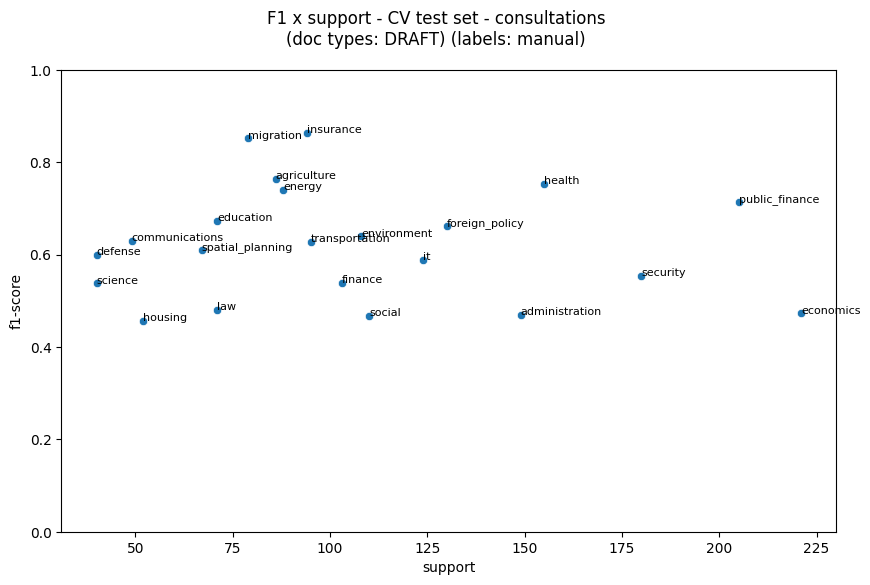

<Figure size 640x480 with 0 Axes>

In [23]:
fig = plotting.plot_score_against_support(
    y_train.values,
    y_cv_predicted_docs,
    target_names=topic_columns,
)
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            "F1 x support - CV test set - consultations",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
plt.tight_layout()
mlflow.log_figure(fig, "cv_score_against_support_consultations.png")
fig

## Training

2025/07/15 10:08:42 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
2025/07/15 10:08:58 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/15 10:09:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

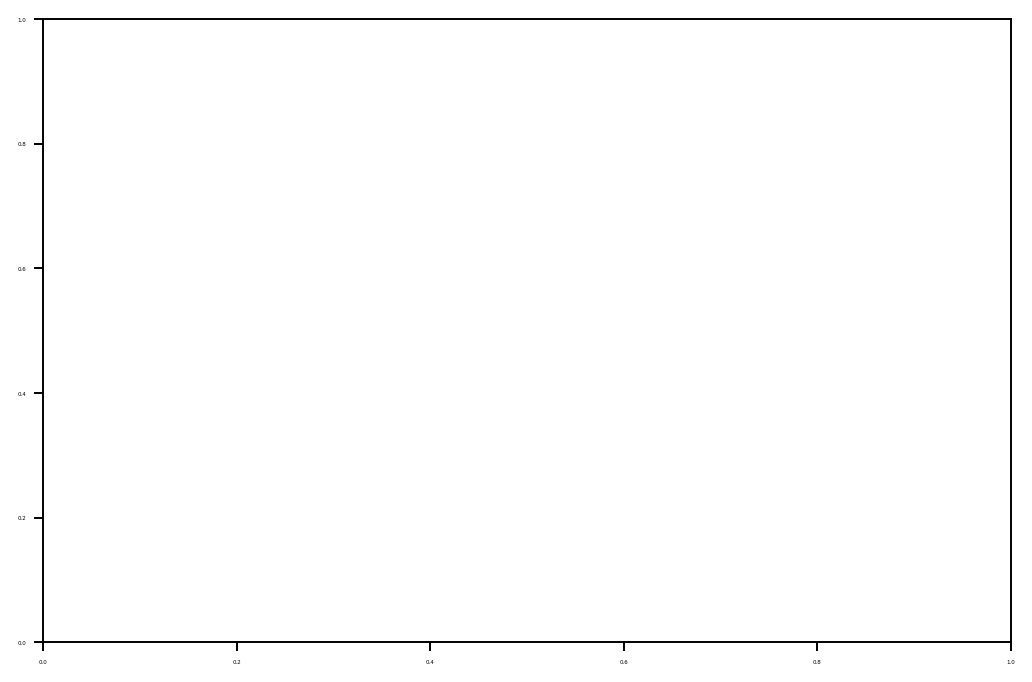

In [24]:
classifier_test = create_classifier(RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [25]:
y_test_predicted = classifier_test.predict(X_test)

2025/07/15 10:09:05 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


In [26]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test,
    y_test_predicted,
    average="samples",
    zero_division=np.nan,
)
scores_consultations = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
utils.log_metrics(**scores_consultations)

{'test_f1': 0.6017, 'test_precision': 0.7234, 'test_recall': 0.6036}


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


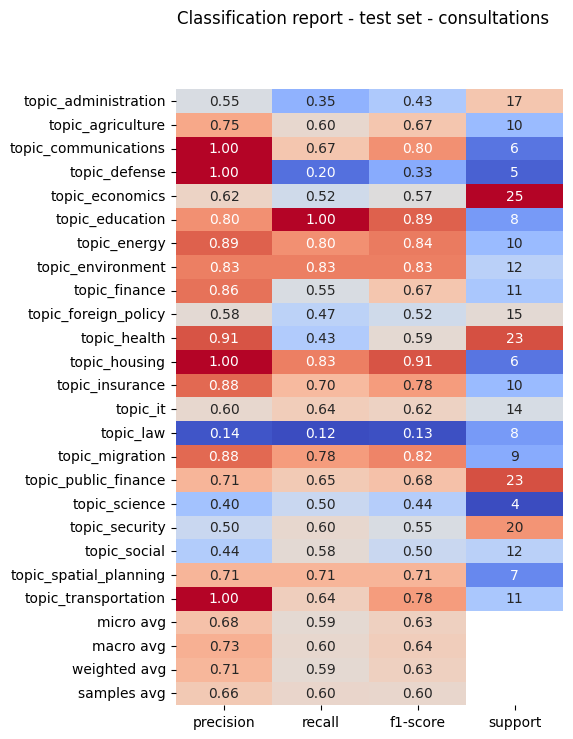

<Figure size 640x480 with 0 Axes>

In [27]:
fig = plotting.plot_classification_report_heatmap(
    y_test.values,
    y_test_predicted,
    target_names=topic_columns,
)
fig.suptitle("Classification report - test set - consultations")
mlflow.log_figure(fig, "test_classification_report_consultations.png")
plt.tight_layout()
display(fig)

## Feature importance

In [28]:
from IPython.core.display import HTML

# After fitting:
#   tfidf: your fitted TfidfVectorizer
#   clf: your fitted OneVsRestClassifier
#   mlb: the MultiLabelBinarizer you used
tfidf = classifier_test.named_steps["tfidfvectorizer"]
clf = classifier_test.named_steps["onevsrestclassifier"]


# 1. Grab the n-gram feature names
feature_names = np.array(tfidf.get_feature_names_out())

# 2. For each class, sort its coefficients
topn = 20  # how many top features you want

rows = []
for idx, class_label in enumerate(topic_columns):
    # coef_ shape is (n_classes, n_features) but for OneVsRestClassifier
    # each estimator.coef_ is shape (1, n_features)
    coef = clf.estimators_[idx].coef_.flatten()

    # top positive features
    top_pos_idx = np.argsort(coef)[-topn:][::-1]
    top_pos = feature_names[top_pos_idx]
    top_pos_weights = coef[top_pos_idx]

    # top negative features (most anti-predictive)
    top_neg_idx = np.argsort(coef)[:topn]
    top_neg = feature_names[top_neg_idx]
    top_neg_weights = coef[top_neg_idx]

    # collect into a DataFrame-friendly structure
    for term, weight in zip(top_pos, top_pos_weights, strict=False):
        rows.append((class_label, "pos", term, weight))
    for term, weight in zip(top_neg, top_neg_weights, strict=False):
        rows.append((class_label, "neg", term, weight))

# 3. Build a DataFrame for nicer display
df_imp = pd.DataFrame(rows, columns=["class", "sign", "ngram", "weight"])

# Now you can, for example, show the top positive n-grams for one class:
for cls in topic_columns:
    display(HTML(f"<h3>{cls}</h3>"))
    print(
        df_imp.loc[(df_imp["class"] == cls) & (df_imp["sign"] == "pos"), ["ngram", "weight"]]
        .sort_values("weight", ascending=False)
        .head(topn)
    )

# # Or pivot to see both pos/neg in one table:
# pivot = df_imp.pivot_table(index="ngram", columns=["class", "sign"], values="weight")
# print(pivot.head(50))

                 ngram    weight
0                  abs  1.320588
1          politischen  1.300353
2             gebühren  1.210747
3   politischen rechte  1.164764
4           government  1.082659
5              kantons  1.008520
6          stimmabgabe  1.003678
7        regierungsrat  0.998007
8                   id  0.961168
9                finma  0.938905
10                 neu  0.929845
11                 ehb  0.923180
12          aufgehoben  0.915603
13           amtlichen  0.910118
14        staatsgrenze  0.875838
15                lkch  0.867045
16         stimmzettel  0.865478
17  verrechnungssteuer  0.856266
18          vermessung  0.856133
19              bundes  0.848731


                    ngram    weight
40         landwirtschaft  3.095313
41                  tiere  2.650096
42                    916  1.736605
43    landwirtschaftliche  1.597549
44   landwirtschaftlichen  1.531899
45                    blw  1.505149
46                 tieren  1.421919
47             jagdgesetz  1.419186
48                 sr 916  1.409425
49                    blv  1.391144
50             massnahmen  1.363053
51                   jagd  1.221986
52                   wald  1.197737
53             organismen  1.189358
54  landwirtschaftsgesetz  1.187980
55           gentechnisch  1.142217
56                    910  1.128214
57  pflanzenschutzmitteln  1.122087
58                 anhang  1.106018
59            erzeugnisse  1.079580


                         ngram    weight
80                       bakom  2.746213
81                        post  2.668316
82                       radio  2.479301
83               anbieterinnen  1.807969
84                      sr 784  1.522974
85                         784  1.489991
86             stromversorgung  1.466820
87               kommunikation  1.455705
88                    symbolen  1.324403
89        raumfahrtaktivitäten  1.322258
90                    reklamen  1.317914
91            fernmeldedienste  1.314418
92  mobilfunkkonzessionärinnen  1.299030
93             prozesshandlung  1.298729
94                         srg  1.225254
95                   fernsehen  1.207941
96            abstimmungsspots  1.192034
97                      zugang  1.164926
98             radio fernsehen  1.155689
99                 alarmierung  1.133355


                                ngram    weight
120                             armee  3.310739
121                               ndb  2.402734
122                     militärischen  1.923731
123           wehrpflichtersatzabgabe  1.758799
124                       zivilschutz  1.679394
125                              jstg  1.677024
126                  landesversorgung  1.611716
127                    kriegsmaterial  1.560941
128                       zivildienst  1.546871
129                          swissgas  1.500969
130                bevölkerungsschutz  1.466067
131                               bsa  1.447189
132                      ersatzabgabe  1.391416
133                       kulturgüter  1.324980
134                      militärische  1.320364
135                               vbs  1.307261
136                              babs  1.301225
137  wirtschaftliche landesversorgung  1.260457
138                         luftraums  1.250711
139               pflichtlagerhaltung  1

                            ngram    weight
160                   unternehmen  1.289244
161                  arbeitnehmer  1.274225
162              erwerbstätigkeit  1.034066
163                         mwstg  1.026496
164                 arbeitsgesetz  0.983485
165             arbeitnehmerinnen  0.854998
166                   arbeitgeber  0.790157
167                 berufsbildung  0.789091
168              ergänzungssteuer  0.775205
169                 weiterbildung  0.769685
170       überbrückungsleistungen  0.720352
171                     tourismus  0.703372
172                    wirtschaft  0.695107
173                           ehb  0.658839
174            regulierungskosten  0.658574
175           beherbergungsabgabe  0.640424
176      arbeitslosenversicherung  0.637701
177               fachhochschulen  0.619980
178    bereitschaftsentschädigung  0.612394
179  staatssekretariat wirtschaft  0.602887


                     ngram    weight
200          berufsbildung  2.336928
201             ausbildung  2.291388
202                    eth  2.054608
203          weiterbildung  1.897559
204                   sbfi  1.854170
205                bildung  1.761459
206                schüler  1.507126
207           schülerinnen  1.409752
208            hochschulen  1.402130
209            beruflichen  1.389939
210                    ehb  1.364920
211           lehrpersonen  1.348415
212           grundbildung  1.338092
213  berufsqualifikationen  1.304804
214            anerkennung  1.269227
215                höheren  1.254682
216    ausbildungsbeiträge  1.252688
217                movetia  1.241452
218                 pflege  1.233685
219        fachhochschulen  1.213845


                    ngram    weight
240               energie  3.429014
241                   bfe  2.159219
242               anlagen  2.040482
243                   co2  1.741200
244       stromversorgung  1.472088
245                 elcom  1.365813
246               prozent  1.257102
247              energien  1.254547
248              planungs  1.215828
249                   734  1.199535
250          stilllegungs  1.154251
251          elektrischer  1.139244
252  elektrischer energie  1.126310
253            massnahmen  1.111468
254     bundesamt energie  1.079317
255          jodtabletten  1.071603
256                 klima  1.062620
257          elektrizität  1.056120
258                 strom  1.007198
259        endverbraucher  1.003405


               ngram    weight
280             bafu  1.945837
281              co2  1.741938
282          anlagen  1.455444
283           umwelt  1.424083
284       massnahmen  1.345792
285      abgeltungen  1.259264
286  fachbewilligung  1.238626
287          energie  1.222167
288         gewässer  1.211943
289       jagdgesetz  1.179992
290            natur  1.151245
291         pflanzen  1.146714
292             jagd  1.096785
293     meteoschweiz  1.082290
294             wald  1.063619
295              gwp  1.058993
296       organismen  1.045670
297         erdbeben  1.021560
298          abfälle  0.979374
299      geologische  0.974016


                        ngram    weight
320                     finma  3.101690
321                      bank  1.824282
322        verrechnungssteuer  1.270649
323               zuwendungen  1.245018
324                   prozent  1.232485
325                    banken  1.208930
326       vorsorgeeinrichtung  1.020394
327                  einlagen  1.015463
328              mietbeiträge  1.003534
329              nationalbank  0.958204
330                 vermieter  0.936548
331                       qif  0.914016
332                       eth  0.913074
333  versicherungsunternehmen  0.895059
334                       dlt  0.889048
335                  mietzins  0.862748
336                       bgs  0.851683
337            staatsbeiträge  0.848528
338                     gespa  0.845182
339                     bankg  0.842018


               ngram    weight
360               eu  2.328272
361          schweiz  2.012696
362  internationalen  1.808239
363            finma  1.497684
364         schengen  1.491144
365    übereinkommen  1.427044
366              ndb  1.391426
367   internationale  1.314664
368     europäischen  1.153890
369    informationen  1.115984
370          staaten  1.113855
371    ausländischen  1.110226
372          betteln  1.078588
373              the  1.047466
374             estv  1.038203
375  vertragsstaaten  0.998510
376          ausland  0.986780
377   übereinkommens  0.964316
378        schweizer  0.924129
379            hamas  0.916792


                   ngram    weight
400  krankenversicherung  2.256587
401                  bag  1.887861
402                  kvg  1.762580
403          versicherer  1.740959
404           gesundheit  1.536285
405                tiere  1.499652
406                  blv  1.357495
407               pflege  1.324785
408             menschen  1.157821
409             covid 19  1.145237
410                covid  1.126779
411        krankenpflege  1.077695
412                  832  1.037245
413   unfallversicherung  1.027119
414           verordnung  1.017896
415        medizinischen  1.009201
416         versicherten  1.003394
417     patientendossier  0.998354
418               sr 832  0.996416
419        behinderungen  0.990832


                   ngram    weight
440                  co2  2.048095
441            wohnungen  1.909703
442              gebäude  1.829595
443  zweitliegenschaften  1.682051
444            mietzinse  1.633582
445         liegenschaft  1.521598
446         grundstücken  1.521220
447                 miet  1.489629
448             erdbeben  1.466450
449           grundstück  1.439808
450                  gwr  1.415898
451                  bsa  1.398585
452       zweitwohnungen  1.375418
453              wohnung  1.370596
454         mietbeiträge  1.275729
455                miete  1.272448
456            vermieter  1.259056
457       liegenschaften  1.203325
458          postfinance  1.189447
459  stockwerkeigentümer  1.189426


                        ngram    weight
480       krankenversicherung  3.064077
481              versicherten  2.634776
482                       kvg  2.311243
483                       ahv  2.002262
484               versicherer  1.983633
485               versicherte  1.840914
486  versicherungsunternehmen  1.784266
487                    alters  1.570118
488     invalidenversicherung  1.543827
489                    sr 831  1.499536
490                       831  1.470324
491                       832  1.469060
492        unfallversicherung  1.391199
493                    sr 832  1.387009
494        versicherte person  1.318532
495                       ifi  1.311055
496                  erdbeben  1.244768
497                   prämien  1.241797
498                leistungen  1.229956
499              versicherung  1.202349


                  ngram    weight
520               daten  5.078174
521       elektronische  1.959146
522      elektronischen  1.626130
523          government  1.412858
524  informationssystem  1.313634
525               bakom  1.301898
526       personendaten  1.242671
527    patientendossier  1.097096
528       informationen  1.077329
529              zugang  1.038026
530           plattform  0.998546
531          telearbeit  0.977241
532               organ  0.952002
533                 art  0.946073
534       anbieterinnen  0.914603
535         stimmabgabe  0.884362
536                 gir  0.850550
537      finanzinstitut  0.832947
538                 vis  0.826368
539                 dlt  0.790221


                    ngram    weight
560                person  1.874386
561               gericht  1.850016
562                   art  1.455741
563                  stgb  1.398573
564                   sem  1.377411
565                   ige  1.248368
566               richter  1.121972
567                justiz  1.073742
568              symbolen  1.067140
569            verfassung  1.053429
570             verfahren  1.048312
571                   zgb  1.021847
572  schaffhauser polizei  1.020414
573       prozesshandlung  1.020104
574            messmittel  1.015958
575          abs geändert  1.004630
576     kantonsverfassung  0.993105
577                  jstg  0.935242
578          schaffhauser  0.930076
579                   ton  0.929996


                        ngram    weight
600                 ausländer  2.651618
601                       sem  2.187414
602            ausländerinnen  2.056630
603                     asylg  1.950234
604                  schengen  1.930607
605                    sr 142  1.769849
606                       the  1.694561
607                       aig  1.646246
608                       142  1.586059
609                aufenthalt  1.504835
610                       bfm  1.502727
611  ausländerinnen ausländer  1.494426
612                        eu  1.488219
613                  personen  1.457442
614    aufenthaltsbewilligung  1.382829
615              europäischen  1.379227
616                      bazg  1.276311
617                    erwerb  1.258068
618            zollverwaltung  1.238211
619                       vis  1.219758


                    ngram    weight
640               franken  1.951730
641          finanzhilfen  1.935054
642              beiträge  1.528580
643         regierungsrat  1.448858
644              darlehen  1.435934
645                steuer  1.126832
646                  estv  1.092740
647    verrechnungssteuer  1.078412
648                    fr  1.063125
649                   000  1.020829
650             förderung  1.017263
651                 mwstg  1.003348
652      steuerpflichtige  0.996771
653                kosten  0.982844
654                abgabe  0.921733
655  verpflichtungskredit  0.901233
656                 globe  0.888789
657      steuerverwaltung  0.881306
658      ergänzungssteuer  0.880361
659                sr 642  0.830184


                  ngram    weight
680                 eth  2.557531
681           forschung  2.143632
682        gentechnisch  2.034962
683          innovation  1.952558
684                 dlt  1.840525
685             movetia  1.728665
686                fifg  1.617704
687        föderalismus  1.597967
688            vorhaben  1.409216
689          klinischen  1.402797
690           förderung  1.362736
691          innosuisse  1.354527
692            pflanzen  1.314200
693         antibiotika  1.312224
694            versuche  1.302445
695         hochschulen  1.262513
696  klinische versuche  1.261119
697       lärmsanierung  1.260821
698           klinische  1.257953
699      fachhochschule  1.230040


                  ngram    weight
720          verordnung  1.063529
721                 art  0.999102
722          sicherheit  0.949106
723             polizei  0.902645
724                  eu  0.899274
725                stgb  0.888439
726     stromversorgung  0.879215
727    landesversorgung  0.876609
728                 ndb  0.846486
729  bevölkerungsschutz  0.815868
730         überwachung  0.812596
731       verordnung eu  0.782350
732          bekämpfung  0.778991
733                 esf  0.769457
734        lebensmittel  0.755266
735             betteln  0.747298
736         zivilschutz  0.741184
737         meldestelle  0.738247
738          versorgung  0.730181
739              verbot  0.707039


                                 ngram    weight
760                                bsv  1.339024
761                          ehegatten  1.267493
762                             person  1.259606
763                          betreuung  1.248441
764                             kindes  1.223482
765                             kinder  1.221458
766                                sgh  1.201978
767                       arbeitnehmer  1.152400
768                             alters  1.120246
769                          förderung  1.030442
770                       bibliotheken  1.012976
771                    zivilgesetzbuch  1.002930
772                               kind  1.001120
773                                abs  0.992577
774                                831  0.989201
775         hinterlassenenversicherung  0.954975
776                             eltern  0.943342
777                             sr 831  0.941854
778  alters hinterlassenenversicherung  0.938821
779                 

                         ngram    weight
800                     bauten  1.872659
801                   bauzonen  1.829998
802                    anlagen  1.495445
803             bauten anlagen  1.495393
804                  wohnungen  1.438976
805                   planungs  1.412083
806                        gwp  1.405766
807                       lkch  1.402923
808               staatsgrenze  1.386784
809                   velowege  1.330070
810                   kataster  1.289877
811                        bau  1.234920
812                      pacht  1.138440
813             zweitwohnungen  1.125947
814  plangenehmigungsverfahren  1.123040
815                 vermessung  1.111702
816                  grundbuch  1.096985
817                  kunst bau  1.088920
818        ausserhalb bauzonen  1.074156
819                  baugesetz  1.046124


                    ngram    weight
840                   bav  2.398587
841               verkehr  2.063274
842              strassen  1.795862
843             fahrzeuge  1.661542
844      nationalstrassen  1.331981
845              verkehrs  1.221849
846               postcom  1.214009
847            fahrzeugen  1.197899
848                   742  1.186568
849                  bazl  1.176611
850              velowege  1.172718
851                   741  1.155491
852                sr 741  1.143100
853                   mda  1.125483
854             taxameter  1.110250
855               schiffe  1.102804
856              fahrzeug  1.089142
857  öffentlichen verkehr  1.083982
858                   sbb  1.065424
859                abgabe  1.034834


***

# End MLflow run

In [29]:
mlflow.end_run()

🏃 View run classy-grub-138 at: https://mlflow.ml1.demokratis.ch/#/experiments/6/runs/04e952a2c1b545ba9c3edd39bd78a883
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/6
